In [71]:
import numpy as np
%matplotlib inline
from matplotlib import pyplot as plt
import os

In [101]:
# SMALL setting
common = {'image_side': 10, 'giveup': 100, 'accuracy_threshold': 0.0, 'repetitions': 1}
parameters = [
    {'optimizer': 'sgd', 'train_batch_size': 1000, 'learning_rate': 0.1, 'epochs': 100, **common},
    {'optimizer': 'frankwolfe', 'train_batch_size': 1000, 'R': 100, 'p': 2, 'gamma': 0.01, 'ro': 0.6,
     'epochs': 200, **common},
    {'optimizer': 'adam', 'train_batch_size': 1000, 'learning_rate': 0.001, 'beta1': 0.9, 'beta2': 0.999, 'epsilon': 1e-08,
     'epochs': 200, **common},
]

In [57]:
[1,2,3]+[4]

[1, 2, 3, 4]

In [51]:
# medium setting
common = {'image_side': 10, 'giveup': 100, 'accuracy_threshold': 0, 'repetitions': 10}
parameters = [
    {'optimizer': 'sgd', 'train_batch_size': 1000, 'learning_rate': lr, 'epochs': 100, **common} for lr in [0.1, 0.01, 0.001, 0.0001]] + \
    [{'optimizer': 'frankwolfe', 'train_batch_size': 1000, 'R': 20, 'p': 2, 'gamma': 0.01, 'ro': 0.6,
     'epochs': 500, **common} for gamma in np.linspace(0, 1, 3) for ro in np.linspace(0, 1, 3)] + \
    [{'optimizer': 'adam', 'train_batch_size': 1000, 'learning_rate': lr, 'beta1': 0.9, 'beta2': 0.999, 'epsilon': 1e-08,
     'epochs': 200, **common} for lr in [0.1, 0.01, 0.001, 0.0001]]

In [59]:
def print_nice(y):
    if isinstance(y, float):
        return str(round(y, 2))#'%.2g' % y
    return str(y)

In [60]:
def print_one(**kwargs):
    print('python experiment.py ' + " ".join(['--' + x + ' ' + print_nice(y) for x, y in kwargs.items()]) + ' &')

In [ ]:
# arguments in the correct order

f = open('experiment.py', 'r').readlines()

args_in_order = []
for l in f:
    k = 'parser.add_argument(\'--'
    if l.startswith(k):
        args_in_order.append(l[len(k):].split('\'')[0])

In [96]:
def get_file(**kwargs):
    return ("_".join([x + '-' + print_nice(kwargs[x] if x in kwargs else None) for x in args_in_order])+'.output')

In [97]:
for params in parameters:
    print_one(**params)
it = len(parameters)
print('Total runs: ', it)
print('Total time: ', it / 6)

python experiment.py --optimizer sgd --train_batch_size 1000 --learning_rate 0.1 --epochs 100 --image_side 10 --giveup 100 --accuracy_threshold 0 --repetitions 1 &
python experiment.py --optimizer frankwolfe --train_batch_size 1000 --R 100 --p 2 --gamma 0.01 --ro 0.6 --epochs 200 --image_side 10 --giveup 100 --accuracy_threshold 0 --repetitions 1 &
python experiment.py --optimizer adam --train_batch_size 1000 --learning_rate 0.0 --beta1 0.9 --beta2 1.0 --epsilon 0.0 --epochs 200 --image_side 10 --giveup 100 --accuracy_threshold 0 --repetitions 1 &
Total runs:  3
Total time:  0.5


In [106]:
def arr_of_dicts_to_dict_of_arrays(arr):
    all_keys = arr[0].keys()
    return {key: [v[key] for v in arr] for key in all_keys}

In [133]:
def process_dict(d, do_plot = True):
    d0 = d
    d = arr_of_dicts_to_dict_of_arrays(d)
    metrics = d
    #print(metrics)
    name = '0'
    if do_plot:
        
        fig, ax1 = plt.subplots()
        ax2 = ax1.twinx()
        
        ax1.set_xlabel('epochs')
        ax1.set_ylabel('loss', color='b')
        ax1.tick_params('y', colors='b')
        
        ax2.set_ylabel('accuracy', color='r')
        ax2.tick_params('y', colors='r')
        
        for i in range(len(d0)):
            ax1.plot(metrics['train_loss'][i], label = 'train_loss')
            ax1.plot(metrics['test_loss'][i], label = 'test_loss')


            ax2.plot(metrics['train_acc'][i], label = 'train_acc')
            ax2.plot(metrics['train_acc'][i], label = 'train_acc')

        fig.tight_layout()
        fig.legend()
        plt.savefig('figures/' + name + '.eps', bbox_inches = 'tight')
        plt.show()

    return d

In [134]:
def process_file(f):
    if not os.path.isfile(f):
        print('File ' + f + ' missing')
        return
    f = open(f, 'r').read()
    if f.startswith('Nothing['):
        print('File ' + f + " is empty")
        return
    d = eval(f)
    return process_dict(d)
    #return d

{'optimizer': 'sgd', 'train_batch_size': 1000, 'learning_rate': 0.1, 'epochs': 100, 'image_side': 10, 'giveup': 100, 'accuracy_threshold': 0.0, 'repetitions': 1}


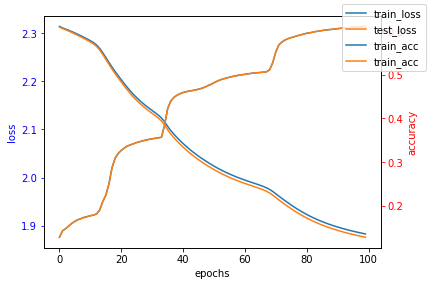

{'optimizer': 'frankwolfe', 'train_batch_size': 1000, 'R': 100, 'p': 2, 'gamma': 0.01, 'ro': 0.6, 'epochs': 200, 'image_side': 10, 'giveup': 100, 'accuracy_threshold': 0.0, 'repetitions': 1}
File optimizer-frankwolfe_image_side-10_giveup-100_accuracy_threshold-0.0_epochs-200_repetitions-1_train_batch_size-1000_R-100_gamma-0.01_p-2_ro-0.6_learning_rate-None_beta1-None_beta2-None_epsilon-None.output missing
{'optimizer': 'adam', 'train_batch_size': 1000, 'learning_rate': 0.001, 'beta1': 0.9, 'beta2': 0.999, 'epsilon': 1e-08, 'epochs': 200, 'image_side': 10, 'giveup': 100, 'accuracy_threshold': 0.0, 'repetitions': 1}


In [137]:
for param in parameters:
    print(param)
    fs = [process_file(get_file(**param))]